# DEMO

## make peaks

In [50]:
from qutip import *
import numpy as np 
import matplotlib.pyplot as plt
import math
from skimage.feature import peak_local_max
import pickle
import os
import glob

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

saveDir = 'peaks'

In [ ]:
EList = np.linspace(0.0093,0.013,2)
wdList = np.linspace(10.57,10.70,2)

In [ ]:
def routine(E_i,wd_i):
    
    print('running param set {} {}'.format(E_i, wd_i))
    
    # Define all the variables 
    kappa = 0.0012 # 0.0012 
    gJC = 0.3347 # 0.3347
    wc = 10.5665 # Cavity frequency/detuning 10.5665
    w0 = 8.1831 # Qubit frequency 8.1831
    gamma=0.0001 # 0.0001
    Emax =0.01 # 0.01
    EN=1
    #E = 0.01 #0.01(original) # Epsilon
    E = E_i
    N = 50 #50
    nloop = 1

    #wd = 10.6005 # Driving frequency (10.6005 original)
    wd = wd_i
    wlist = np.linspace(wd, wd,nloop)

    # Identity operators are defined for the space of the light field and the space of the atom

    ida = identity(N)
    idatom = identity(2)

    # Define cavity field and atomic operators

    a  = tensor(destroy(N),idatom)
    sm = tensor(ida,sigmam())

    # Hamiltonian # Reminder check hamiltonian from caltech paper

    H1= 1*gJC*(a.dag()*sm + sm.dag()*a) + 1*E*(a+a.dag())

    # Collapse Operators

    C1    = math.sqrt(kappa)*a
    C2    = math.sqrt(gamma)*sm

    C1dC1 = C1.dag()*C1
    C2dC2 = C2.dag()*C2

    # Calculate the Liouvillian

    L1 = spre(C1)*spost(C1.dag())-0.5*spre(C1dC1)-0.5*spost(C1dC1)
    L2 = spre(C2)*spost(C2.dag())-0.5*spre(C2dC2)-0.5*spost(C2dC2)
    L12  = L1+L2

    gQ=math.sqrt(4)
    xvec=  np.arange(-10,10.01,0.025) # 0.025
    yvec = np.arange(-10,10.01,0.025) 

    #print("epsilon", E)
    #print("and drive frequency", wd)
    #print("kappa", kappa)
    k=0
    while k < nloop :
        wl = wlist[k]    
        H = (w0-wl)*(sm.dag()*sm) + (wc-wl)*(a.dag()*a) + H1    
        LH = -complex(0,1) * (spre(H) - spost(H))
        L_final = LH + L12

        # Steady States

        rhoss = steadystate(L_final)
        rhosscav=ptrace(rhoss,0)
        rhocavsq=rhosscav*rhosscav

        #subplot(ceil(sqrt(nloop)), 
        #ceil(sqrt(nloop)), k)
#         fig, ax = plt.subplots()
        Q3 = qfunc(rhosscav,xvec,yvec,gQ)
#         c = ax.contourf(xvec, yvec, np.real(Q3), 500, cmap=plt.cm.get_cmap('winter'))

#         ax.set_xlim([-3.5, 6]) # -3.5 to 6
#         ax.set_ylim([-4, 3])
#         plt.colorbar(c, ax=ax)
#         plt.xlabel('x')
#         plt.ylabel('y')

        k += 1
        #contour(xvec,yvec,real(Q3), 500)
        #plt.plot(xvec,yvec)
        #plt.show()
        #print(rhosscav)
        #print(rhoss)
    
    coordinates = peak_local_max(Q3)
    #print(coordinates)
    #print (Q3[coordinates])
    
    infoPacket = {}
    infoPacket['E_i'] = E_i
    infoPacket['wd_i'] = wd_i
    infoPacket['coors'] = coordinates
    infoPacket['peaks'] = Q3[coordinates]
    infoPacket['Q3'] = Q3
    infoPacket['xvec'] = xvec
    infoPacket['yvec'] = yvec
    return infoPacket
            

In [ ]:
saveIdx = 0

if os.path.exists(saveDir):
    print('SAVE FOLDER ALREADY EXISTS. MOVE/DELETE IT AND TRY AGAIN!')

for E_i in EList:
    for wd_i in wdList:
        infoPacket = routine(E_i,wd_i)
        
        if not os.path.exists(saveDir):
            os.makedirs(saveDir)        
        pickle.dump(infoPacket, open(os.path.join(saveDir,'{}.qpeak'.format(saveIdx)),'wb'))
        saveIdx += 1

## read peaks

In [36]:
relevantInfo = []
for peak in glob.glob(os.path.join(saveDir, '*')):
    savedInfo = pickle.load(open(peak, 'rb'))    
    
    coors = savedInfo['coors']    
    peaks = []
    for coor in coors:        
        peaks.append(savedInfo['Q3'][coor[0], coor[1]])     
        
    relevantInfo_i = {}
    relevantInfo_i['peakName'] = peak
    relevantInfo_i['E'] = savedInfo['E_i']
    relevantInfo_i['wd'] = savedInfo['wd_i']
    relevantInfo_i['peaks'] = peaks
    relevantInfo.append(relevantInfo_i)
    
print(len(relevantInfo))

1600


In [56]:
count = 0
peakLen = 0
for relevantInfo_i in relevantInfo:
    if len(relevantInfo_i['peaks']) == peakLen:
        count += 1
print(count)

0


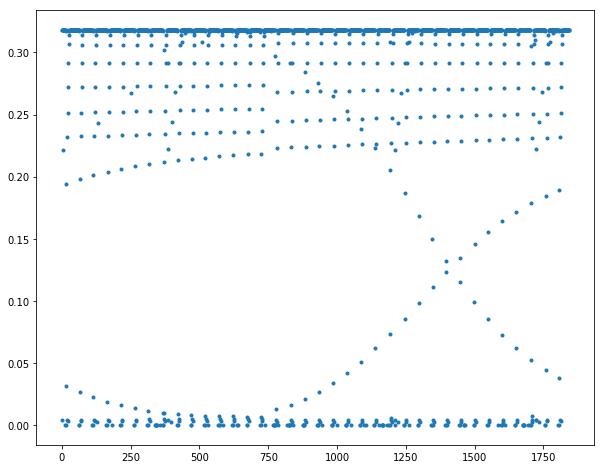

In [59]:
peaksTest = []
for relevantInfo_i in relevantInfo:
    for j in relevantInfo_i['peaks']:
        peaksTest.append(j)
plt.plot(peaksTest, '.')

In [84]:
#todo1: play with peaktrimlimit to affect width of leaf
#todo2: if 1 peak r = nothing? that might be the grey region

numIgnored = 0
plotData = []
peakTrimLimit = 0.05
for relevantInfo_i in relevantInfo:
    
    trimmedPeaks = []
    foundPeaks = relevantInfo_i['peaks']
    for foundPeak_i in foundPeaks:
        if foundPeak_i > peakTrimLimit:
            trimmedPeaks.append(foundPeak_i)
    
    if len(trimmedPeaks) == 1:
        r = 1
        plotData.append((relevantInfo_i['E'], relevantInfo_i['wd'], r))
        #continue
    elif len(trimmedPeaks) == 2:
        peak0 = relevantInfo_i['peaks'][0]
        peak1 = relevantInfo_i['peaks'][1]
        r = 1 - (abs(peak0-peak1)/(peak0+peak1))
        if r < 0.01:
            print(peak0)
            print(peak1)
            break
        plotData.append((relevantInfo_i['E'], relevantInfo_i['wd'], r))
    else:
        numIgnored += 1
    #ignoreif more than 2 peaks
print(len(plotData))
print(numIgnored)

1600
0


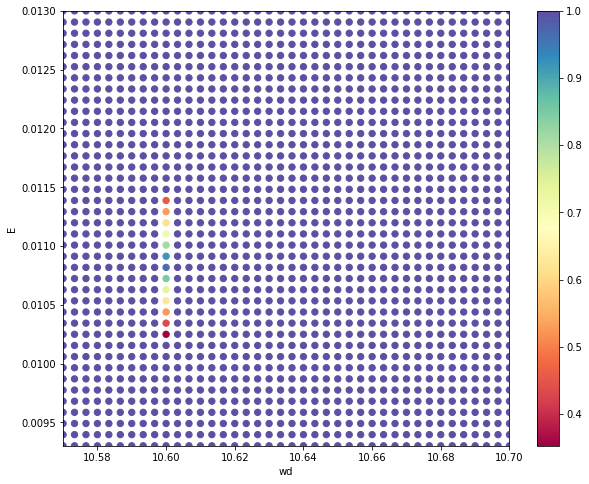

In [85]:
plt.scatter([i[1] for i in plotData], [i[0] for i in plotData], c=[i[2] for i in plotData], s=40, cmap=plt.cm.Spectral)
plt.ylabel("E")
plt.xlabel("wd")
plt.ylim(min([i[0] for i in plotData]), max([i[0] for i in plotData]))
plt.xlim(min([i[1] for i in plotData]), max([i[1] for i in plotData]))
plt.colorbar()


In [31]:
savedInfoTest = pickle.load(open(os.path.join(saveDir,'3.qpeak'), 'rb'))
print(savedInfoTest.keys())
print(savedInfoTest)

dict_keys(['E_i', 'wd_i', 'coors', 'peaks', 'Q3', 'xvec', 'yvec'])
{'E_i': 0.0092999999999999992, 'wd_i': 10.58, 'coors': array([[400, 389]], dtype=int64), 'peaks': array([[[  3.71981499e-42,   6.03714302e-42,   9.78587612e-42, ...,
           3.86383369e-46,   2.33972550e-46,   1.41393322e-46],
        [  3.46027758e-42,   5.61591545e-42,   9.10307879e-42, ...,
           4.96952922e-46,   3.03914073e-46,   1.85567570e-46]]]), 'Q3': array([[  1.27063246e-85,   2.06129774e-85,   3.33980115e-85, ...,
         -5.09309191e-87,  -3.21748216e-87,  -2.02921751e-87],
       [  2.09520430e-85,   3.39898621e-85,   5.50720856e-85, ...,
         -8.39814953e-87,  -5.30376654e-87,  -3.34401954e-87],
       [  3.45054122e-85,   5.59773654e-85,   9.06978057e-85, ...,
         -1.38264673e-86,  -8.72937698e-87,  -5.50230146e-87],
       ..., 
       [  2.69844315e-85,   4.37760420e-85,   7.09282702e-85, ...,
         -1.46887481e-86,  -9.26933073e-87,  -5.83999518e-87],
       [  1.63754064e-85,   2

In [ ]:
print(routine(savedInfoTest['E_i'],savedInfoTest['wd_i']))

old ranges:

EList = np.linspace(0.0093,0.013,2)
wdList = np.linspace(10.57,10.70,2)

new ranges:
wd from 10.594 to 10.607

E from 0.0095 to 0.01225